## Paln 
--------------------------------------
1. EDA (1주)
1. Image size Check.
2. BB(Bounding Box ) 틀린게 있는지, 어디에 있는지?
3. BB에 따른 confidence 설정?

--------------------------------------
2. Vision algorithm (2주 ~ 5주)
1. RCNN 계열(RCNN →Faster RCNN etc)
2. 기존 비전처리 Opencv처리
3. YOLO V1 ~ V4 / PP-YOLO
4. Detection  + Segmentation(Mask RCNN, U-net, U-net ++  etc)
5 . Transformer  → VIT로 이어지는 결과로.

In [1]:
!pip install kaggle --upgrade

# !kaggle competitions download -c global-wheat-detection

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
import glob
import re
import torch 
import torch.nn as nn
import torchvision



from PIL import Image, ImageDraw,ImageFont
from ast import literal_eval
from tqdm import tqdm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator



import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [97]:
root_path = './global-wheat-detection (1)/'

train_folder = os.path.join(root_path, "train")
test_folder = os.path.join(root_path, "test")
train_csv_path = os.path.join(root_path, "train.csv")
sample_submission = os.path.join(root_path, "sample_submission.csv")

In [77]:
train_folder

'./global-wheat-detection (1)/train'

In [36]:
# !pip install pillow

In [38]:
# from PIL import Image
# import glob
# test_images = []
# for filename in glob.glob('./global-wheat-detection (1)/test/*.jpg') : 
#     im = Image.open(filename)
#     test_images.append(im)

In [98]:
df = pd.read_csv(train_csv_path)

In [99]:
df

image_id  width  height                         bbox     source
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1
...           ...    ...     ...                          ...        ...
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2

[147793 rows x 5 columns]

In [40]:
# width == height check!

df['width'].unique() == df['height'].unique() == [1024]

array([ True])

In [100]:
#box - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]
def get_bbox_area(bbox):
    bbox = literal_eval(bbox)
    return bbox[2] * bbox[3]

In [101]:
df['bbox_area'] = df['bbox'].apply(get_bbox_area)

In [102]:
df

image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2   

        bbox_area  
0          2016.0  
1          7540.0  
2         11840.0  
3         11663.0  
4         14508.0  
...           ...  
147788     7980.0  
147789     8774.0  
147790    10011.0  
147791    14536.0  
147792     5734.0  

[147793 rows x 6 columns]

<AxesSubplot:>

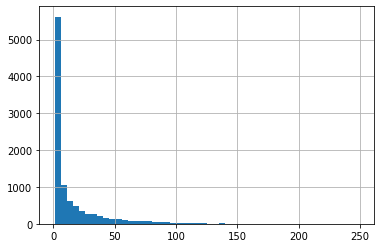

In [46]:
df['bbox_area'].value_counts().hist(bins=50)

In [103]:
unique_images = df['image_id'].unique()
len(unique_images)

3373

In [104]:
from PIL import Image
import glob
train_images = []
for filename in glob.glob('./global-wheat-detection (1)/train/*.jpg') : 
    im = Image.open(filename)
    train_images.append(im)
print(len(train_images))

3422


In [105]:
len(os.listdir(train_folder))

3422

In [106]:
num_total = len(os.listdir(train_folder))
num_annotated=len(unique_images)

print('Bbox가 없는 사진의 수 : {}개 '.format( num_total - num_annotated))

Bbox가 없는 사진의 수 : 49개 


In [107]:
sources = df['source'].unique()

print('Source 의 columns : {} '.format (sources))

Source 의 columns : ['usask_1' 'arvalis_1' 'inrae_1' 'ethz_1' 'arvalis_3' 'rres_1' 'arvalis_2'] 


In [108]:
df['source'].value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

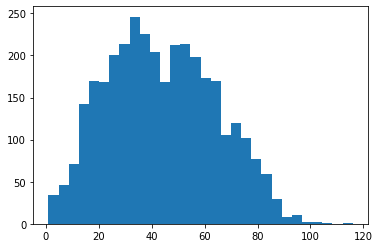

In [109]:
plt.hist(df['image_id'].value_counts(), bins=30)
plt.show()

# Visualizing images

In [110]:
def show_images(images, num = 5):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_folder, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in df[df['image_id'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], width=3)

        plt.figure(figsize = (15,15))
        plt.imshow(image)
        plt.show()

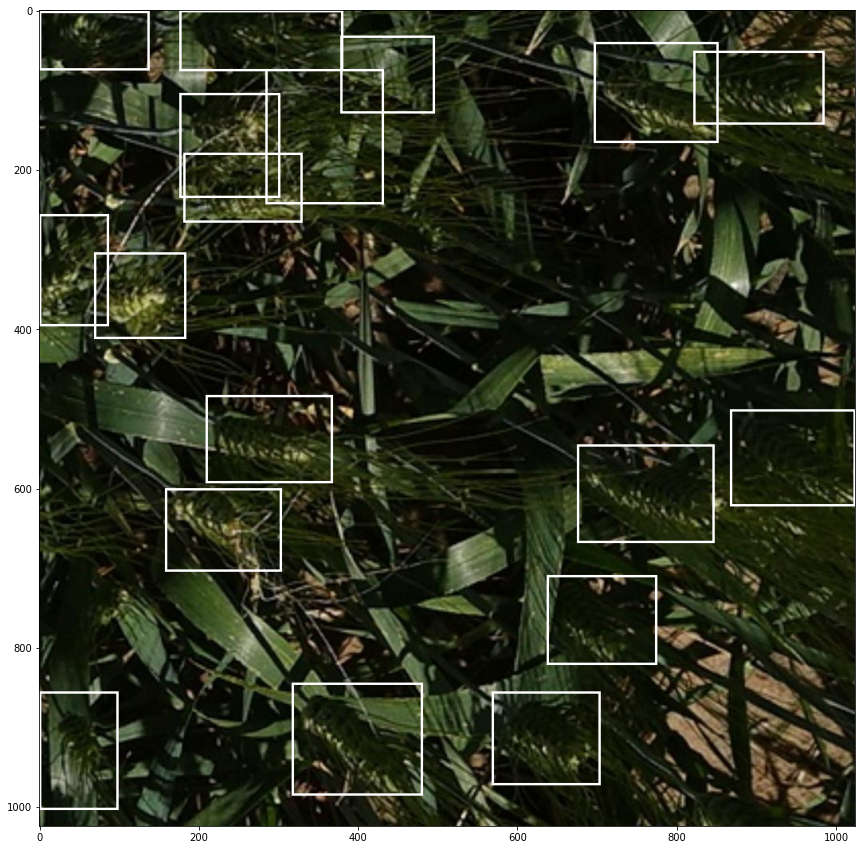

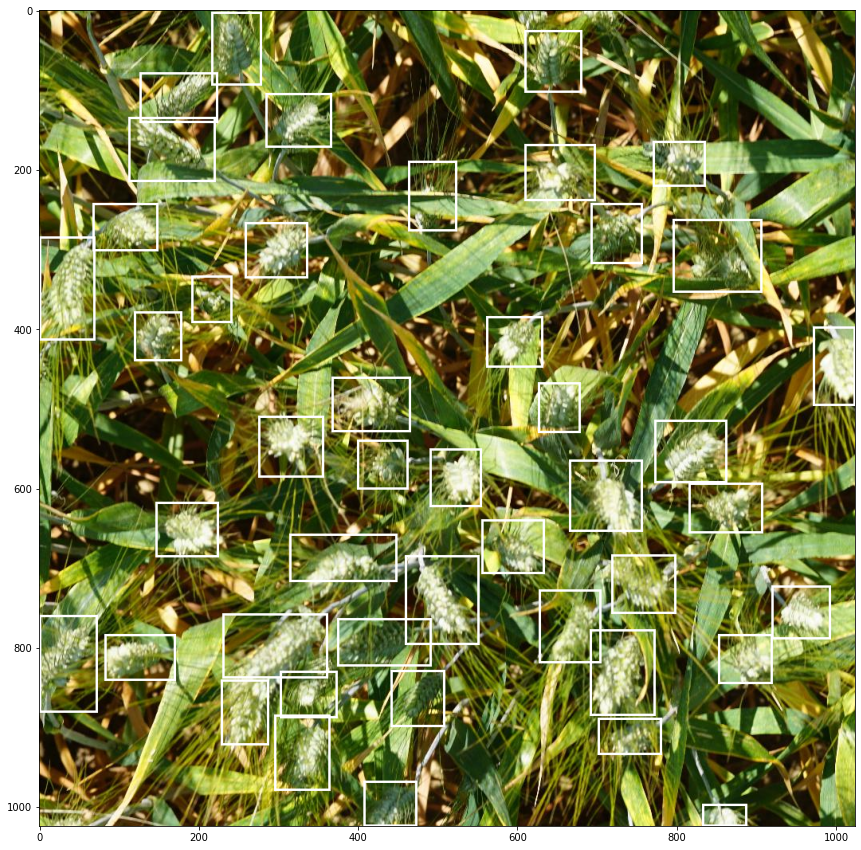

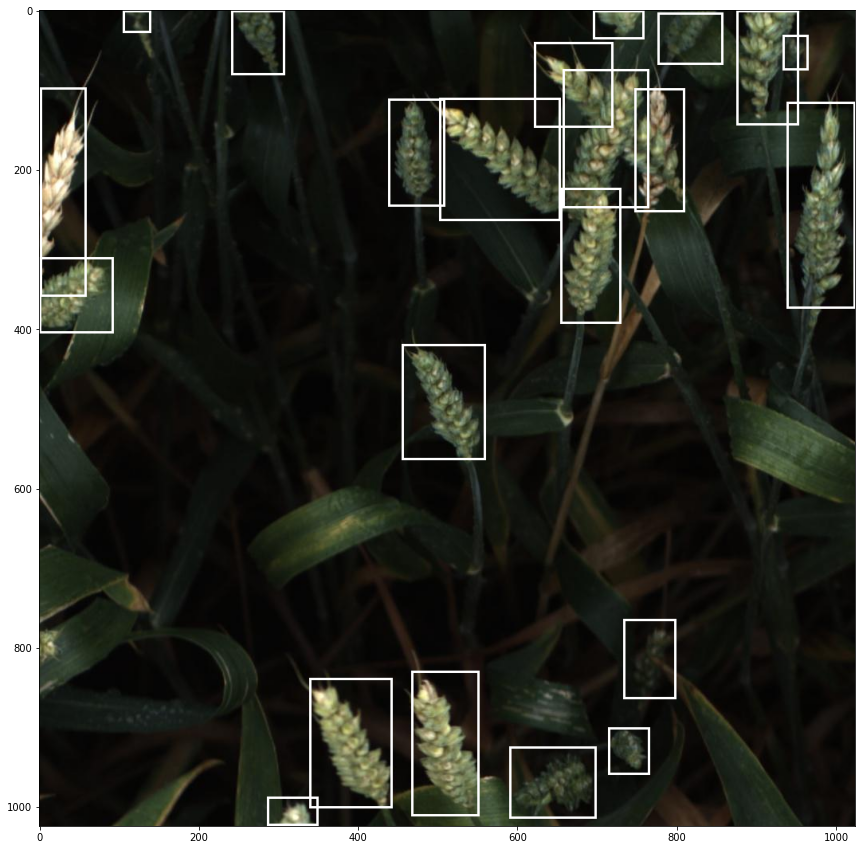

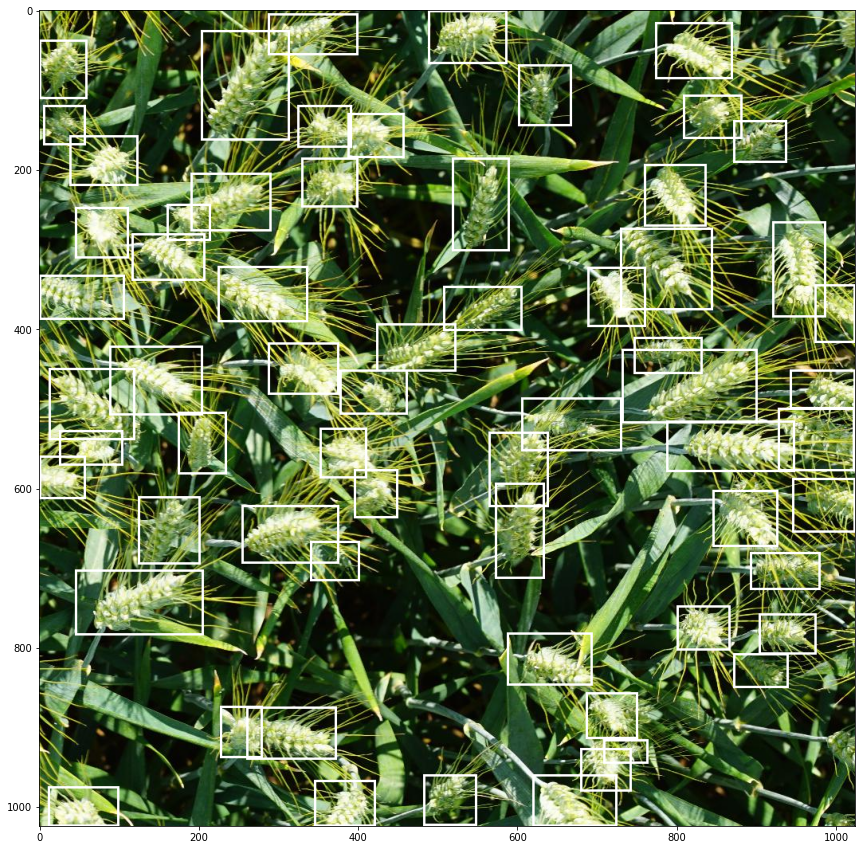

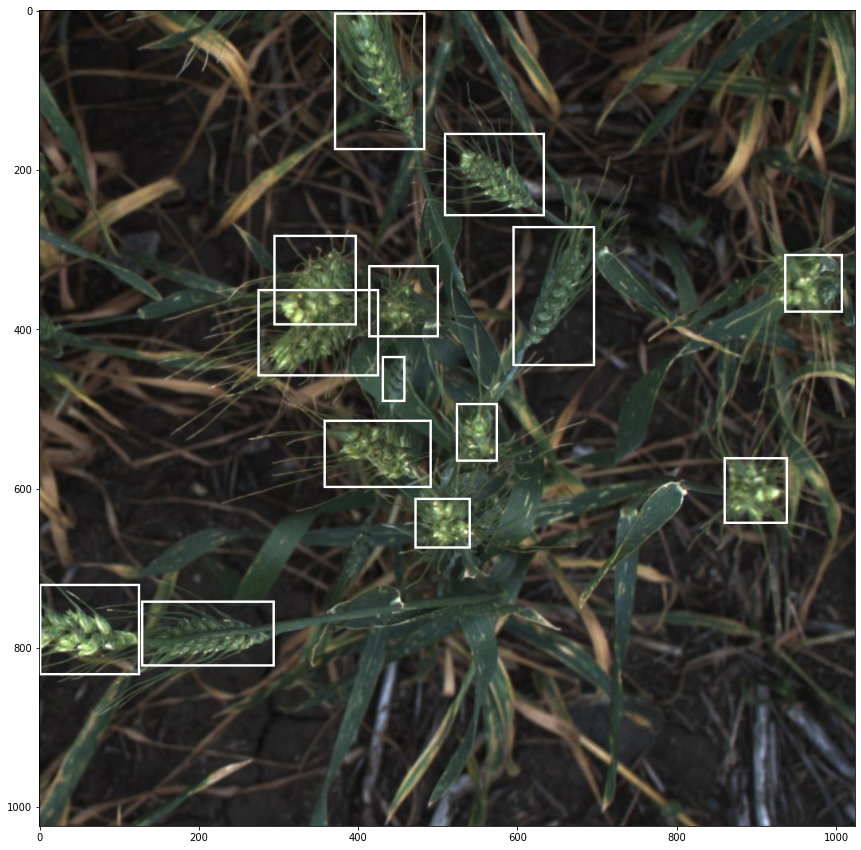

In [111]:
show_images(unique_images)

In [112]:
bboxs = [ bbox[1:-1].split(',') for bbox in df['bbox']]

bboxs=[ f"{int(float(bbox[0]))},{int(float(bbox[1]))},{int(float(bbox[0]))+int(float(bbox[2]))},{int(float(bbox[1])) + int(float(bbox[3]))},wheat" for bbox in bboxs]
df['bbox_']=bboxs
df.head()

image_id  width  height                         bbox   source  bbox_area  \
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1     2016.0   
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1     7540.0   
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1    11840.0   
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1    11663.0   
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1    14508.0   

                   bbox_  
0  834,222,890,258,wheat  
1  226,548,356,606,wheat  
2  377,504,451,664,wheat  
3   834,95,943,202,wheat  
4   26,144,150,261,wheat

In [116]:
df['x'] = -1
df['y'] = -1
df['w'] = -1
df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

df[['x', 'y', 'w', 'h']] = np.stack(df['bbox'].apply(lambda x: expand_bbox(x)))
df.drop(columns=['bbox'], inplace=True)
df['x'] = df['x'].astype(np.float)
df['y'] = df['y'].astype(np.float)
df['w'] = df['w'].astype(np.float)
df['h'] = df['h'].astype(np.float)

In [117]:
df

image_id  width  height     source  bbox_area                  bbox_  \
0       b6ab77fd7   1024    1024    usask_1     2016.0  834,222,890,258,wheat   
1       b6ab77fd7   1024    1024    usask_1     7540.0  226,548,356,606,wheat   
2       b6ab77fd7   1024    1024    usask_1    11840.0  377,504,451,664,wheat   
3       b6ab77fd7   1024    1024    usask_1    11663.0   834,95,943,202,wheat   
4       b6ab77fd7   1024    1024    usask_1    14508.0   26,144,150,261,wheat   
...           ...    ...     ...        ...        ...                    ...   
147788  5e0747034   1024    1024  arvalis_2     7980.0   64,619,148,714,wheat   
147789  5e0747034   1024    1024  arvalis_2     8774.0  292,549,399,631,wheat   
147790  5e0747034   1024    1024  arvalis_2    10011.0  134,228,275,299,wheat   
147791  5e0747034   1024    1024  arvalis_2    14536.0    430,13,614,92,wheat   
147792  5e0747034   1024    1024  arvalis_2     5734.0  875,740,969,801,wheat   

            x      y      w      h  
0       834.0  222.0   56.0   36.0  
1       226.0  548.0  130.0   58.0  
2       377.0  504.0   74.0  160.0  
3       834.0   95.0  109.0  107.0  
4        26.0  144.0  124.0  117.0  
...       ...    ...    ...    ...  
147788   64.0  619.0   84.0   95.0  
147789  292.0  549.0  107.0   82.0  
147790  134.0  228.0  141.0   71.0  
147791  430.0   13.0  184.0   79.0  
147792  875.0  740.0   94.0   61.0  

[147793 rows x 10 columns]

In [125]:
images_ids = df['image_id'].unique()
print(len(images_ids))

3373


## My custom data split is train : valid= 8: 2 

In [130]:
3373 * 0.2 

674.6

In [128]:
train_ids = images_ids[:-674]
valid_ids = images_ids[-674:]
print(train_ids.shape, valid_ids.shape)

(2699,) (674,)


In [137]:
valid_ids

array(['d728e2fc2', 'b5e726c10', '2ff4e8bb0', '30f54e611', 'a326e7d8e',
       'a3bcd1d0f', '382bf4ed7', 'be589b720', '97372d371', 'bbce58f71',
       'b45096c1e', 'b3c96d5ad', '1be796d9d', 'ba9133208', 'ac891ac35',
       'a5904a10b', 'ea0e9e846', '92f3b252f', '59d43a53f', '290ae67be',
       '8afea785a', '44b7163ea', 'd1f73158a', 'fabaeac81', 'b57f67edf',
       'c8defc0d1', '5f5181592', '38b19d4f5', 'f233cfd8b', '2391f283f',
       '07479da31', '5e182e37e', 'ce3999eb9', '03d831c0d', 'e721e6416',
       '228f94f80', '4b127eb47', '6f119c82d', 'a6c205e19', '2c836cccb',
       'f54ff03a2', '09f97e0cf', 'b46dce732', '9658b9c3c', 'f5b320e47',
       '6b4169a72', 'f415daf80', '99886a700', '0c2d20111', '1b3376c60',
       '5e30f8f4d', 'ab81b2342', 'abcb46fc1', 'e05767cda', 'ca664da7d',
       '93c9d721e', 'f84383b38', '56105ed87', '18df0fea9', '14d024cc4',
       '89fb3f19c', 'aa82bfd6a', '42f5fe6a5', 'd39457b35', 'b7c9166b6',
       'd011146e3', '69e509038', '3ee6fd90a', 'aec95891a', '6b84

In [138]:
df['image_id'].isin(valid_ids)

0         False
1         False
2         False
3         False
4         False
          ...  
147788     True
147789     True
147790     True
147791     True
147792     True
Name: image_id, Length: 147793, dtype: bool

In [135]:
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]

In [139]:
train_df, valid_df

(         image_id  width  height     source  bbox_area                  bbox_  \
 0       b6ab77fd7   1024    1024    usask_1     2016.0  834,222,890,258,wheat   
 1       b6ab77fd7   1024    1024    usask_1     7540.0  226,548,356,606,wheat   
 2       b6ab77fd7   1024    1024    usask_1    11840.0  377,504,451,664,wheat   
 3       b6ab77fd7   1024    1024    usask_1    11663.0   834,95,943,202,wheat   
 4       b6ab77fd7   1024    1024    usask_1    14508.0   26,144,150,261,wheat   
 ...           ...    ...     ...        ...        ...                    ...   
 122603  33ea56e1c   1024    1024  arvalis_3     7383.0    5,419,112,488,wheat   
 122604  33ea56e1c   1024    1024  arvalis_3    10349.0  448,596,527,727,wheat   
 122605  33ea56e1c   1024    1024  arvalis_3     6177.0  225,176,296,263,wheat   
 122606  33ea56e1c   1024    1024  arvalis_3     4958.0    12,481,79,555,wheat   
 122607  33ea56e1c   1024    1024  arvalis_3     5846.0   171,87,245,166,wheat   
 
             x

In [ ]:
class WheatDataset(Dataset):
    
    
    def __init__(self,dataframe, image_dir, transformes = None):
        super.()__init__()
        
        self.image_ids = DataFrame['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transformes = transforms
        
    def __getitem__(self, index : int ):
        
        image_id = self.image_ids[index]
        recodes = self.df[self.df['image id'] == image_id]
        
        image = cv2.imread(f '{self.image_dir/{image_id}.jpg}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BAYER_BG2BGR).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x','y','w','h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        
        
        
        
        
        
        